In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))
from utils.utils import save_experiment, train_and_evaluate_linear_svm, grid_search_model, evaluate_model_on_parquet
from configs.config_local import FEATURES_DIR, ITW_DATASET_PATH, MODELS_PATH

In [2]:
train_data_path = os.path.join(FEATURES_DIR, "training_features_20_128_256_128.parquet")
test_data_path = os.path.join(FEATURES_DIR, "testing_features_20_128_256_128.parquet")

df = pd.read_parquet(train_data_path)
df_test = pd.read_parquet(test_data_path)
#print(df.head())
print(df_test.head())
print(df_test.shape)
#df.shape()

svc_params = {
            "C": 1000,
            "class_weight": "balanced",
            "max_iter": 20000,
            "random_state": 42
        }
pipeline, metrics, svc_params, feature_names, metadata_extra = train_and_evaluate_linear_svm(train_data_path, test_data_path, svc_params)

  label                                           filename  mfcc_mean_0  \
0  real    file1.wav_16k.wav_norm.wav_mono.wav_silence.wav  -611.930420   
1  real   file10.wav_16k.wav_norm.wav_mono.wav_silence.wav  -605.008606   
2  real  file100.wav_16k.wav_norm.wav_mono.wav_silence.wav  -597.774414   
3  real  file1000.wav_16k.wav_norm.wav_mono.wav_silence...  -601.991211   
4  real  file1001.wav_16k.wav_norm.wav_mono.wav_silence...  -624.717590   

   mfcc_std_0  mfcc_mean_1  mfcc_std_1  mfcc_mean_2  mfcc_std_2  mfcc_mean_3  \
0   72.226364    12.266665   42.255665   -12.647933   31.396906    22.397125   
1   89.047852    -0.973098   43.327984   -12.821069   30.010666    38.964752   
2   55.831722     7.211399   28.566553   -16.026072   20.905310    50.700493   
3   84.732544   -23.718582   54.874195    -9.058393   29.486805    42.911995   
4   89.558777   -23.051550   46.054176   -12.977422   40.239491    38.695904   

   mfcc_std_3  ...  mel_spectrogram_mean_123  mel_spectrogram_std_12

In [3]:
print(metrics)

{'accuracy': 0.7235649546827795, 'precision': 0.7267903374622742, 'recall': 0.7247882840571931, 'f1': 0.7231880209179744, 'roc_auc': 0.8010816895528619}


In [4]:
save_experiment(
    model=pipeline,
    metrics=metrics,
    experiment_dir=os.path.join(sys.path[0], "notebooks", "experiments", "linear_svm"),
    model_params=svc_params,
    feature_names=feature_names,
    metadata_extra=metadata_extra,
)


Experiment saved to: c:\Users\Konstantinos\Documents\GitHub\audio-deepfake-detection\notebooks\experiments\linear_svm\exp_20260130_145632


'c:\\Users\\Konstantinos\\Documents\\GitHub\\audio-deepfake-detection\\notebooks\\experiments\\linear_svm\\exp_20260130_145632'

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import os
model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",  LinearSVC(max_iter=20000, random_state=42)),
])

param_grid = {
    "svm__C": [0.1, 1, 10, 100],  # maybe stop at 100 for RBF
    "svm__class_weight": [None, "balanced",{0:1,1:5}],
}

train_data_path = os.path.join(FEATURES_DIR, "training_features_20_128_256_128.parquet")
test_data_path = os.path.join(FEATURES_DIR, "testing_features_20_128_256_128.parquet")



best_model, metrics, best_params_, metadata, feature_names = grid_search_model(
    model,
    param_grid,
    train_data_path,
    test_data_path,
    scoring= "recall",
    cv = 5,
    n_jobs= 1,
    verbose = 2,
)

print(best_params_)
print(metrics)


save_experiment(
    model=best_model,
    metrics=metrics,
    experiment_dir=os.path.join(sys.path[0], "notebooks", "experiments",  "linear_svm",),
    model_params=best_params_,
    feature_names=feature_names,
    metadata_extra=metadata,
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=   3.5s
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=   3.6s
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=   3.2s
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=   4.1s
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=   3.8s
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time=   3.7s
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time=   3.8s
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time=   3.5s
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time=   4.0s
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time=   3.9s
[CV] END .........svm__C=0.1, svm__class_weight={0: 1, 1: 5}; total time=   3.7s
[CV] END .........svm__C=0.1, svm__class_weight=

'c:\\Users\\Konstantinos\\Documents\\GitHub\\audio-deepfake-detection\\notebooks\\experiments\\linear_svm\\exp_20260130_150217'

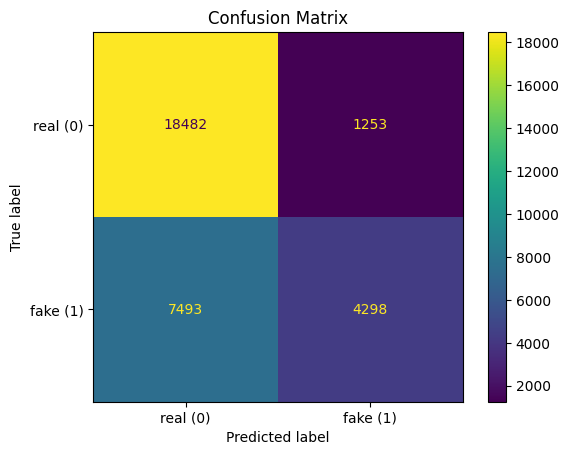

{'accuracy': 0.7225781894309459, 'precision': 0.7742749054224464, 'recall': 0.36451530828598083, 'f1_macro': 0.6521692757444713, 'roc_auc': 0.7367116799501632}


In [7]:
itw_test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_20_128_256_128_trimmed_loudness_normalized.parquet")
metrics, metadata_extra = evaluate_model_on_parquet(best_model, itw_test_data_path, plots=True)
print(metrics)
#{'accuracy': 0.7140138298547231, 'precision': 0.8621769772905247, 'recall': 0.28012891188194383, 'f1': 0.6163872650983102}

### Model trained only on mean features

In [8]:
train_data_path = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
test_data_path = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet")

df = pd.read_parquet(train_data_path)
df_test = pd.read_parquet(test_data_path)
#print(df.head())
print(df_test.head())
print(df_test.shape)
#df.shape()
svc_params = {
            "C": 0.1,
            "class_weight": {0: 1, 1: 5},
            "max_iter": 20000,
            "random_state": 42
        }
pipeline, metrics, svc_params, feature_names, metadata_extra = train_and_evaluate_linear_svm(train_data_path, test_data_path, svc_params)
print(metrics)

  label                                           filename  mfcc_mean_0  \
0  real    file1.wav_16k.wav_norm.wav_mono.wav_silence.wav  -611.930420   
1  real   file10.wav_16k.wav_norm.wav_mono.wav_silence.wav  -605.008606   
2  real  file100.wav_16k.wav_norm.wav_mono.wav_silence.wav  -597.774414   
3  real  file1000.wav_16k.wav_norm.wav_mono.wav_silence...  -601.991211   
4  real  file1001.wav_16k.wav_norm.wav_mono.wav_silence...  -624.717590   

   mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  mfcc_mean_5  \
0    12.266665   -12.647933    22.397125   -18.097271     6.636819   
1    -0.973098   -12.821069    38.964752   -17.512388    -5.345759   
2     7.211399   -16.026072    50.700493   -41.957108    -4.920807   
3   -23.718582    -9.058393    42.911995   -23.795502    -0.905054   
4   -23.051550   -12.977422    38.695904   -18.944435    -0.490484   

   mfcc_mean_6  mfcc_mean_7  ...  mel_spectrogram_mean_118  \
0   -13.808917     1.950459  ...                  0.104165   
1   

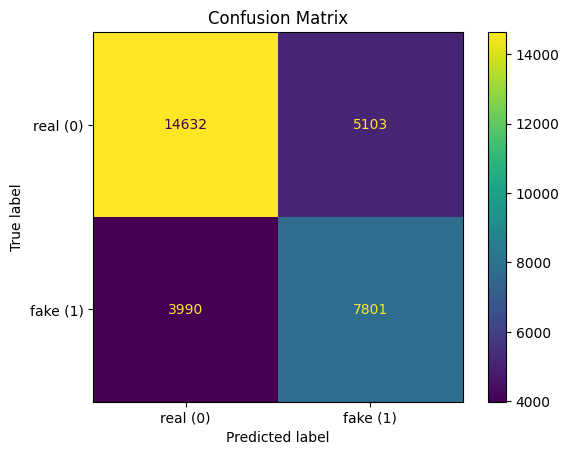

{'accuracy': 0.7115714013829855, 'precision': 0.6045412275263484, 'recall': 0.6616063098973793, 'f1_macro': 0.6973627379350705, 'roc_auc': 0.7650501749314883}


In [11]:
itw_test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet")
metrics, metadata_extra = evaluate_model_on_parquet(pipeline, itw_test_data_path, plots=True)
print(metrics)
#{'accuracy': 0.7140138298547231, 'precision': 0.8621769772905247, 'recall': 0.28012891188194383, 'f1': 0.6163872650983102}